# Head Velocity
Notebook for clean attempt of checking the distribution of head velocity including the direction.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats, integrate, signal

%matplotlib inline
sns.set(color_codes=True)

# loading data
df = {}
event = {}

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]
                                                                            
path = '../datasets/'

for i, x in enumerate(fname):
    df[i] = pd.read_hdf(path+x+'_filter.h5', 'Full')
    event[i] = pd.read_hdf(path+'analysis/'+x+'_event.h5', 'Event')      
                                                                                                                                    

In [2]:
# in use functions
def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta


def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta0'] = np.arccos(CosTheta)
    return df


def angle_orig(df):
    V1 = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])
    V2 = np.array([1       , 0       , 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['thetaOrig'] = np.arccos(CosTheta)
    return df


def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


## All experiments analysis
Mergning event log and filetered data from experiments. Removing useless columns. Calculating the flattened vector in XZ plane (lx1, lz1) - including sing, and normalization to unitvector lenght. 

In [3]:
DF = {}

for i, x in enumerate(fname):
    DF[i] = pd.merge(event[i], df[i], on='Frame')

    #clearing data off useless variables
    DF[i].rename(columns={"Time_Ori":'Time'}, inplace=True)
    DF[i].drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)
    print('done %d' % i)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7


In [4]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
for i, x in enumerate(fname):
    DF[i] = DF[i].apply(decompose_vec_df, axis=1)
    DF[i]['V1'] = np.linalg.norm(np.array([DF[i].lx1, 0, DF[i].lz1]))

    # propagate the sign of a X, Z to new vector
    DF[i]['lx1'] = DF[i].apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
    DF[i]['lz1'] = DF[i].apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

    # normalize the data to unit vector form
    DF[i]['lx1'] = DF[i].apply(lambda row: row.lx1 / row.V1, axis=1)
    DF[i]['lz1'] = DF[i].apply(lambda row: row.lz1 / row.V1, axis=1)

    DF[i].dropna(inplace=True)
    print('done %d' % i)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7


## Angle and Velocity
Calculating the angle between orientation 2D vector and origin set to XZ(1,0). Substracting the angles between iterations to calculate change of angle in each iteration. Based on that: dV = dTheta / dTime

In [5]:
# calculatinig the angles between X axis and the vectors
for i, x in enumerate(fname):
    DF[i] = DF[i].apply(angle_orig, axis=1) # calculation between two vectors(does not include direction) -  theta
    DF[i] = DF[i].apply(angle_zero, axis=1) # calculation with origin

    DF[i]['theta1'] = DF[i].theta0.shift(1)
    DF[i]['theta']  = DF[i].apply(lambda row: row.theta0 - row.theta1, axis=1)
    DF[i].drop({'theta0','theta1'}, axis=1, inplace=True)
    print('done %d' % i)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7


In [6]:
# angular velocity
for i, x in enumerate(fname):
    DF[i]['U']     = DF[i].apply(lambda row: np.degrees(row.theta)     / row.dTime, axis=1) #between two vectors velocity
    DF[i]['UOrig'] = DF[i].apply(lambda row: np.degrees(row.thetaOrig) / row.dTime, axis=1)
    DF[i].dropna(inplace=True)
    print('done %d' % i)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7


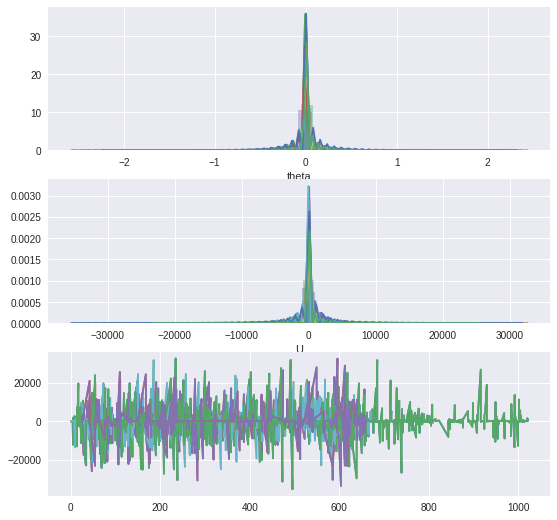

In [7]:
# U and theta distributions

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
for i, x in enumerate(fname):

    sns.distplot(DF[i].theta, ax=ax1)
    sns.distplot(DF[i].U    , ax=ax2)
    c2 = ax3.plot(DF[i].Time, DF[i].U)


## Filtering velocity values

In [8]:
# Pick the hyperparameters for analysis
hyperparam = { 'windowSize': 30  ,
               'limitDT'   : 0.15,
               'limitVAng' : 100 ,
               'DmaxPerc'  : 0.2 ,}

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7


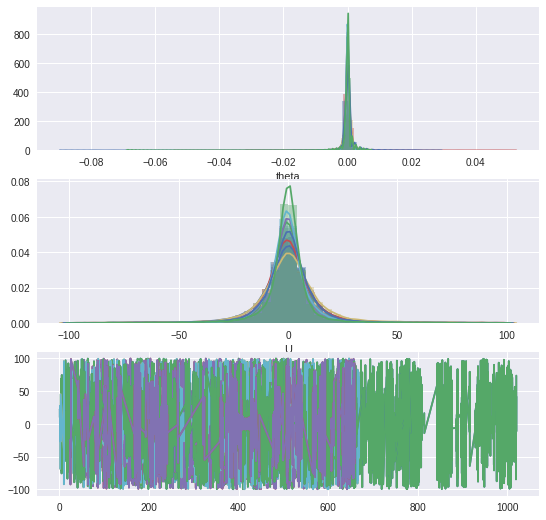

In [9]:
# U and theta distributions with limited velocity
vlim = 100

for i, x in enumerate(fname):
    DF[i] = DF[i][DF[i]['dTime'] < hyperparam['limitDT']]
    DF[i] = DF[i][DF[i]['U'] < vlim]
    DF[i] = DF[i][DF[i]['U'] >-vlim]
    print('done %d' % i)

# U and theta distributions
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
for i, x in enumerate(fname):

    sns.distplot(DF[i].theta, ax=ax1)
    sns.distplot(DF[i].U    , ax=ax2)
    c2 = ax3.plot(DF[i].Time, DF[i].U)

## Angular velocity analysis
Comparison of velocity logged per even with calculated velocit (substraction and correlation). Addtional smoothing of the data applied.

In [10]:
for i, x in enumerate(fname):
    # smoothing the data
    DF[i]['M']     = DF[i]['U'].rolling(window=50).mean()

    # substraction
    DF[i]['subU']  = DF[i].apply(lambda row: row.speed - row.U, axis=1)
    DF[i]['subM']  = DF[i].apply(lambda row: row.speed - row.M, axis=1)

    # correlation
    DF[i]['corr']  = signal.correlate(DF[i].speed, DF[i].U, mode='same') / 128
    DF[i]['corrM'] = signal.correlate(DF[i].speed, DF[i].M, mode='same') / 128
    print('done %d' % i)
    

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7


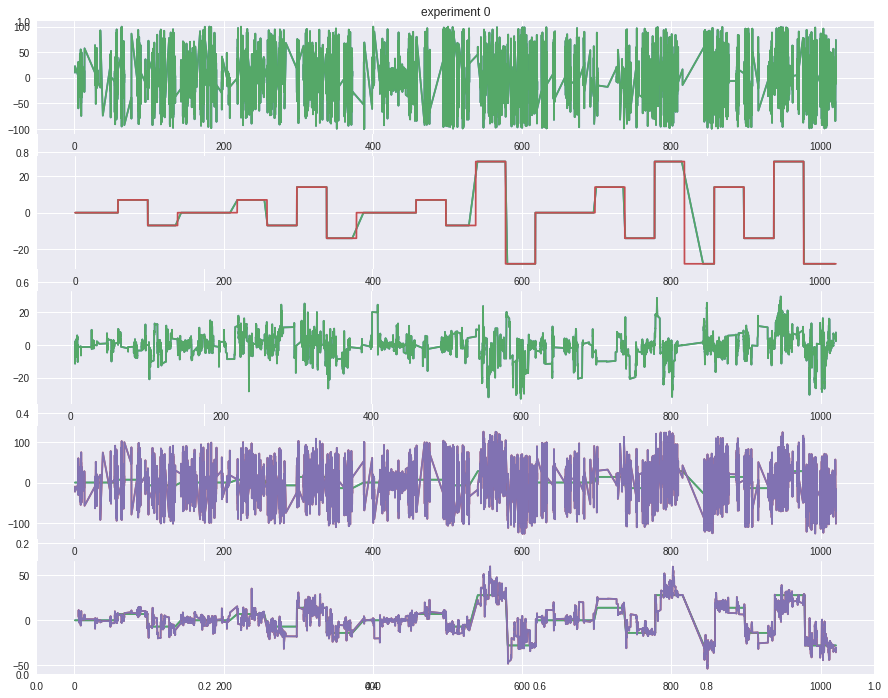

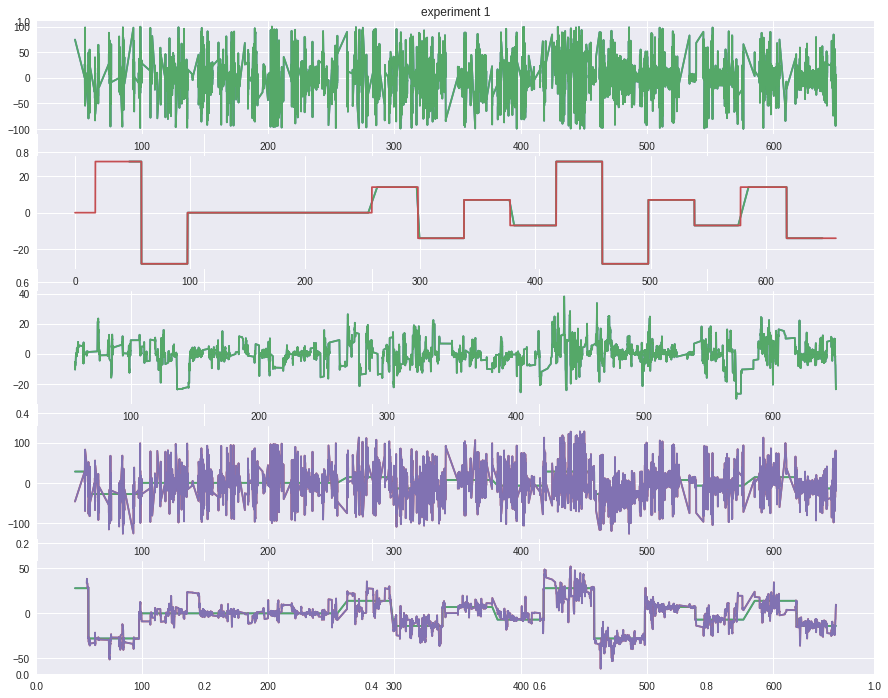

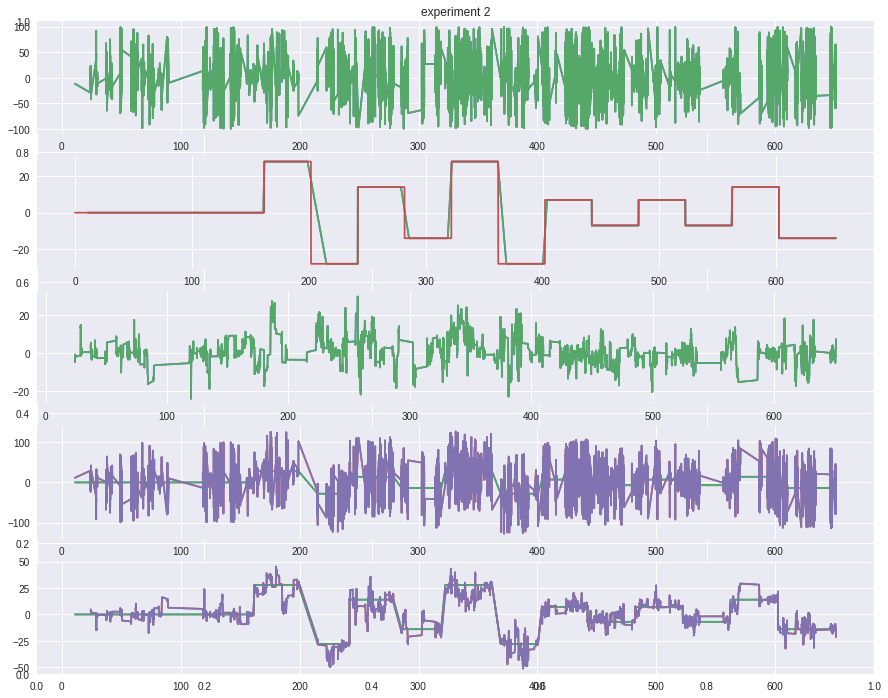

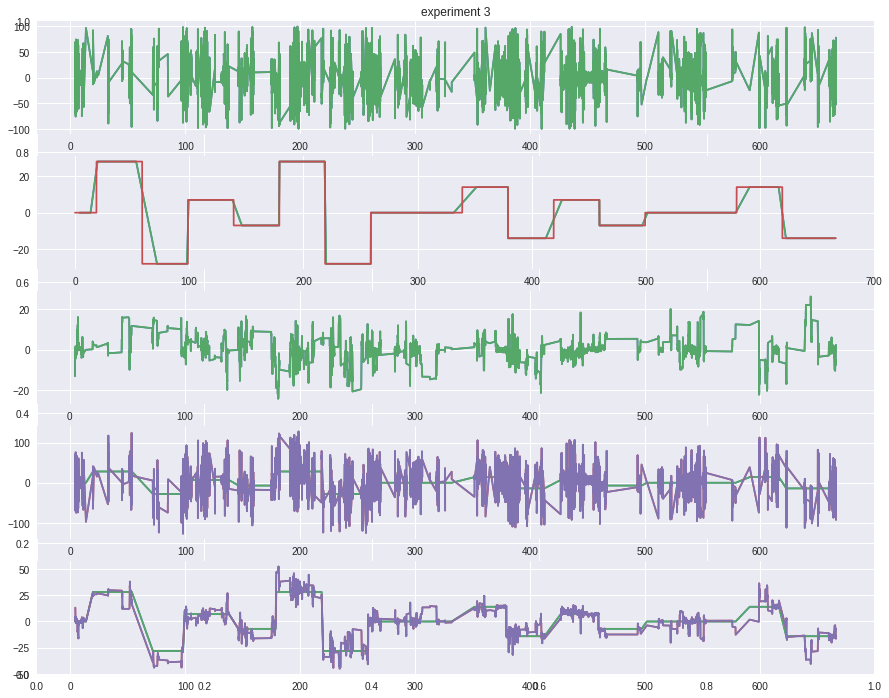

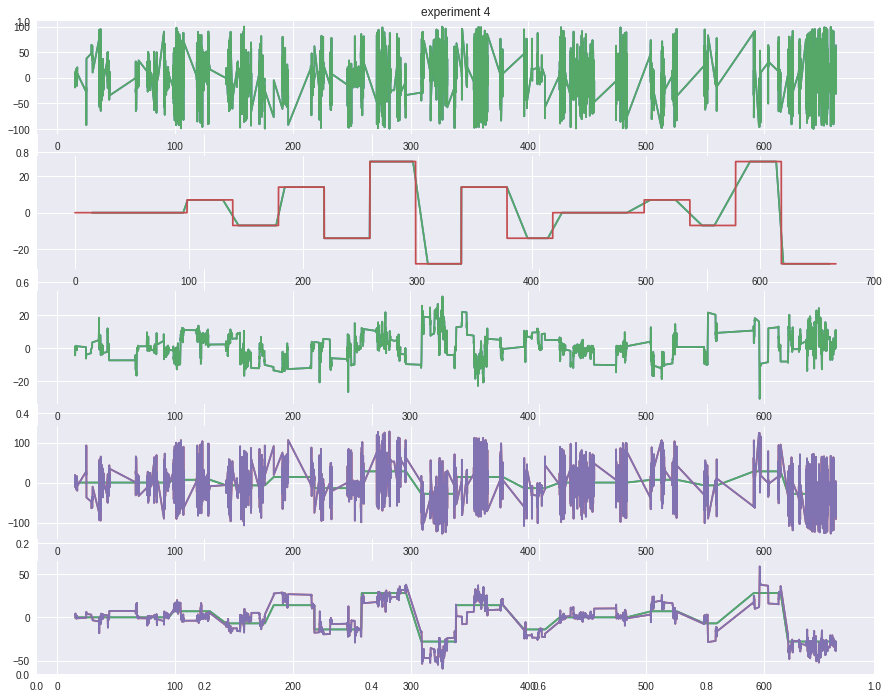

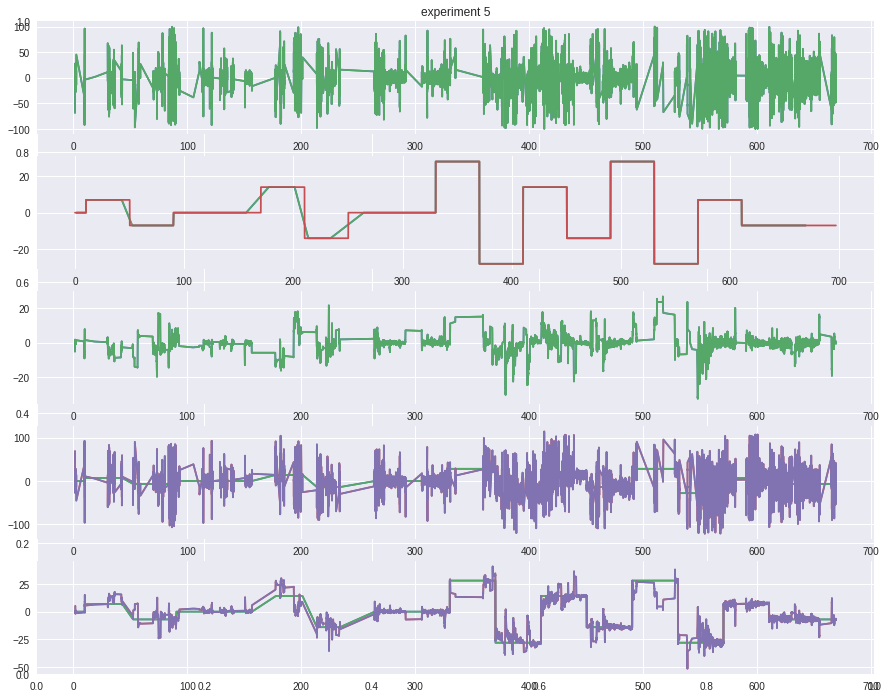

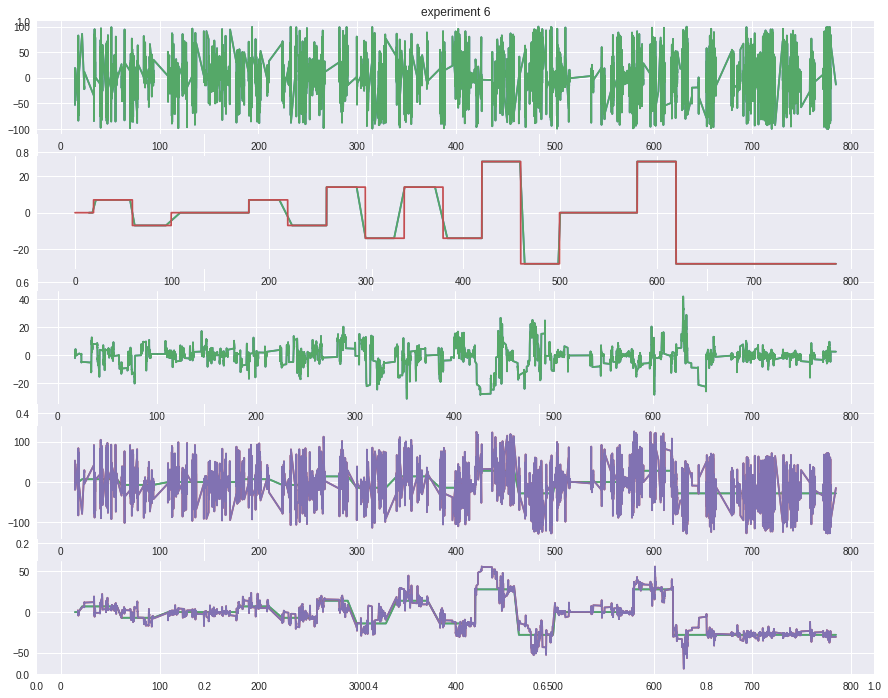

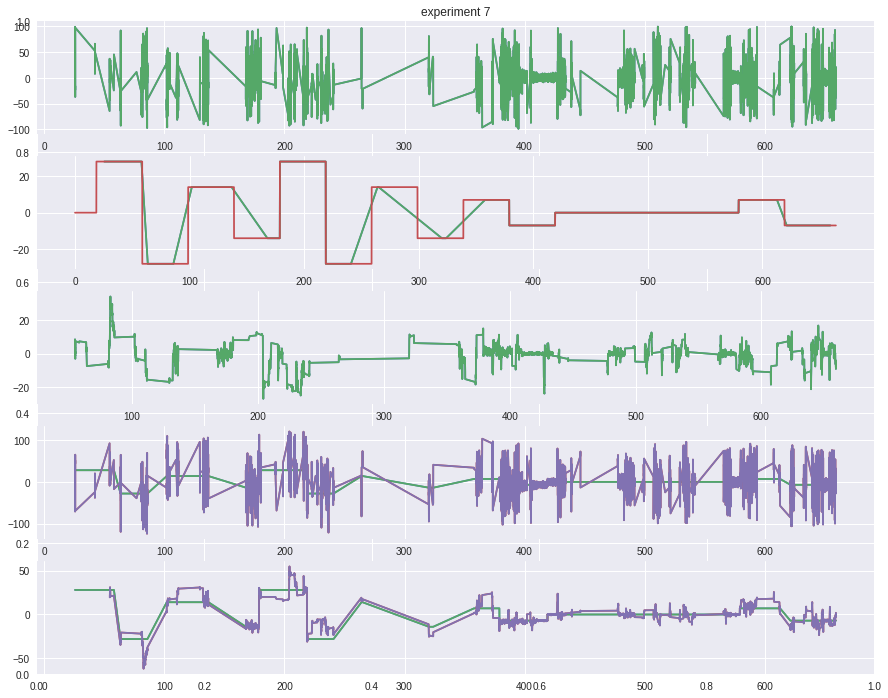

In [11]:
for i, x in enumerate(fname):
    ## Plotting
    fig = plt.figure(figsize=(15,12))
    plt.title('experiment %d' % i)
    ax1 = fig.add_subplot(511)
    ax2 = fig.add_subplot(512)
    ax3 = fig.add_subplot(513)
    ax4 = fig.add_subplot(514)
    ax5 = fig.add_subplot(515)

    c1 = ax1.plot(DF[i].Time, DF[i].U)
    c2 = ax2.plot(DF[i].Time, DF[i].speed, event[i].Time, event[i].speed)
    c3 = ax3.plot(DF[i].Time, DF[i].M)
    c3 = ax4.plot(DF[i].Time, DF[i].speed, DF[i].Time, DF[i].subU)
    c5 = ax5.plot(DF[i].Time, DF[i].speed, DF[i].Time, DF[i].subM)


## Stimulus-related behavior
Looking for frames detected as SRB. According to:
SRB = {f E FRAMES: ||Vhead - Vstim|| < Dmax}

In [13]:
# creation of needed dataset
dfSRB = {}

for i, x in enumerate(fname):
    dfSRB[i] = DF[i].copy()
    dfSRB[i].drop({'MotiveExpTimeSecs', 'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz', 'lx1', 'lz1', 'V1',
                'thetaOrig', 'theta', 'UOrig', 'M', 'corr','corrM', 'subU', }, axis=1, inplace=True)

    dfSRB[i].dropna(inplace=True)


In [17]:
sumSRB, dfSRBVis, dfSRBInvis, sumSRBVis, sumSRBInvis = {}, {}, {}, {}, {}

for i, x in enumerate(fname):
    # setting Dmax as 20% of velocity at given moment // what about 0
    dfSRB[i]['Dmax'] = dfSRB[i].apply(lambda row: row.speed * hyperparam['DmaxPerc'], axis=1)
    dfSRB[i]['Dmax'] = dfSRB[i].apply(lambda row: 0.1 if row.Dmax == 0 else row.Dmax, axis=1)
    dfSRB[i]['SRB']  = dfSRB[i].apply(lambda row: np.absolute(row.subM) < np.absolute(row.Dmax), axis=1)

    # checking lenght of SRB frames in the filtered experiment data
    sumSRB[i] = len(dfSRB[i][dfSRB[i]['SRB']] == True)

    #  temp dataframes with stimuli being present or not
    dfSRBVis[i]   = dfSRB[i][ dfSRB[i]['visible']]
    dfSRBInvis[i] = dfSRB[i][~dfSRB[i]['visible']]

    sumSRBVis[i]  = len(dfSRBVis[i]  [dfSRBVis[i]['SRB']])
    sumSRBInvis[i]= len(dfSRBInvis[i][dfSRBInvis[i]['SRB']])


exp 0; stimulus-related behavior: 6.439932%
exp 1; stimulus-related behavior: 4.984502%
exp 2; stimulus-related behavior: 6.756988%
exp 3; stimulus-related behavior: 3.736897%
exp 4; stimulus-related behavior: 6.585136%
exp 5; stimulus-related behavior: 4.620034%
exp 6; stimulus-related behavior: 4.738821%
exp 7; stimulus-related behavior: 5.381803%

exp 0; SRM when stimuli is visible: 8.289828%
exp 1; SRM when stimuli is visible: 5.600249%
exp 2; SRM when stimuli is visible: 8.899659%
exp 3; SRM when stimuli is visible: 4.439638%
exp 4; SRM when stimuli is visible: 8.151012%
exp 5; SRM when stimuli is visible: 5.188905%
exp 6; SRM when stimuli is visible: 6.824012%
exp 7; SRM when stimuli is visible: 5.199334%

exp 0; SRM when stimuli is invisible: 2.359060%
exp 1; SRM when stimuli is invisible: 2.317227%
exp 2; SRM when stimuli is invisible: 2.178582%
exp 3; SRM when stimuli is invisible: 2.333071%
exp 4; SRM when stimuli is invisible: 2.159661%
exp 5; SRM when stimuli is invisible: 

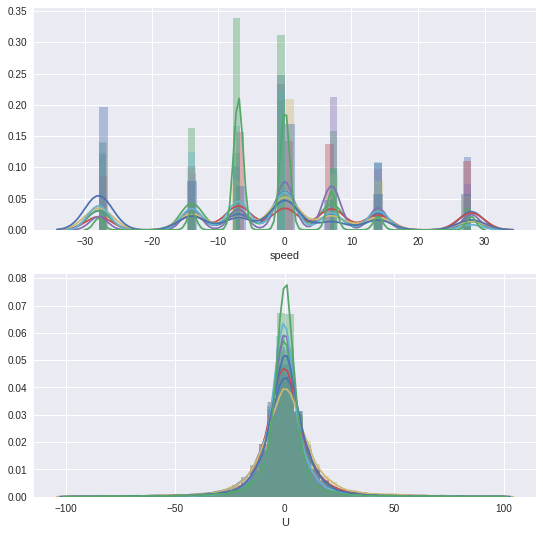

In [16]:
# SRB presentation
for i, x in enumerate(fname):
    print('exp %d; stimulus-related behavior: %f%%'     % (i, sumSRB[i]      * 100 / len(dfSRB[i])     ))
print()

for i, x in enumerate(fname):
    print('exp %d; SRM when stimuli is visible: %f%%'   % (i, sumSRBVis[i]   * 100 / len(dfSRBVis[i])  ))
print()

for i, x in enumerate(fname):    
    print('exp %d; SRM when stimuli is invisible: %f%%' % (i, sumSRBInvis[i] * 100 / len(dfSRBInvis[i])))
print()

    
# analysis of the stimuli per speed 
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for i, x in enumerate(fname):
    sns.distplot(dfSRB[i].speed, ax=ax1)
    sns.distplot(dfSRB[i].U    , ax=ax2)

In [20]:
i = 2
print(fname[i])
pd.set_option('display.max_rows', 2000)
print(dfSRB[i][dfSRB[i]['SRB']])


VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU
        Frame        Time  visible  speed        Time          U      subM  \
211      7039   29.329169     True    0.0   29.329169  -7.876000  0.021517   
214      7042   29.341669     True    0.0   29.341669  -2.927413  0.092542   
215      7043   29.345835     True    0.0   29.345835   3.665739 -0.027573   
238      7066   29.441669     True    0.0   29.441669   0.706463 -0.071799   
243      7071   29.462502     True    0.0   29.462502  -1.513158 -0.093551   
245      7073   29.470835     True    0.0   29.470835  -6.669906  0.094185   
254      7082   29.508335     True    0.0   29.508335   4.859029 -0.040221   
269      7097   29.570835     True    0.0   29.570835 -12.089259  0.081414   
270      7098   29.575002     True    0.0   29.575002  -9.895315  0.081371   
289      7117   29.654169     True    0.0   29.654169   3.900947  0.089049   
303      7131   29.712502     True    0.0   29.712502   8.873805  0.034765   
304      7133   29.720